In [68]:
import random
import json
import re

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix

random.seed(6)
np.random.seed(6)


# Experiment 7 - Llama3.1 8b as a judge

In this experiment I implement the technique `LLM as judge` used in the paper `How good is my MML?` as evaluaiton metric for the correctness of the answers given by a model. The method 
consists of using a LLM to evaluate the correctness of the answers given by another model. The LLM acts as a judge by comparing the predicted answer with the ground truth answer and providing a score between 0 and 5, expressing the confidence in the answer. The judge also provides a reason for the score.


**Parameters:**
- model: llama3.1 8b
- system prompt: LLM_judge_system.txt
- temperature: 0.1
- sampling method: (default) top-p (p=0.9)


Let's load the ground truth from the `STAR_QA_question_and_stsg_val.json` file where we extracted QA and spatio-temporal scene graphs

In [69]:
ground_truth = []

with open('../data/datasets/STAR_QA_and_stsg_val.json') as f:
    data = json.load(f)
    ground_truth = [{
        'id': sample['question_id'],
        'question': sample['question'],
        'choices': sample['choices'],
        'num': sample['answer'],
        'text': sample['choices'][str(sample['answer'])]
    } for sample in data]


# we keep num as str so we can directrly access choices dictionaries
gt_df = pd.DataFrame(ground_truth).astype({'id': 'string', 'num': 'string', 'text': 'string'})
gt_df.set_index('id', inplace=True)
gt_df


,question,choices,num,text
id,,,,
Interaction_T1_13,Which object was tidied up by the person?,"{'0': 'The closet/cabinet.', '1': 'The blanket...",2,The clothes.
Interaction_T1_14,Which object was tidied up by the person?,"{'0': 'The blanket.', '1': 'The table.', '2': ...",2,The clothes.
Interaction_T1_31,Which object was thrown by the person?,"{'0': 'The pillow.', '1': 'The bag.', '2': 'Th...",2,The clothes.
Interaction_T1_32,Which object was put down by the person?,"{'0': 'The food.', '1': 'The shoe.', '2': 'The...",1,The shoe.
Interaction_T1_40,Which object was tidied up by the person?,"{'0': 'The broom.', '1': 'The closet/cabinet.'...",1,The closet/cabinet.
...,...,...,...,...
Feasibility_T6_1453,What is the person able to do after taking the...,"{'0': 'Wash the table.', '1': 'Take the box.',...",0,Wash the table.
Feasibility_T6_1454,What is the person able to do after walking th...,"{'0': 'Take the towel.', '1': 'Throw the bag.'...",0,Take the towel.
Feasibility_T6_1455,What is the person able to do after walking th...,"{'0': 'Throw the bag.', '1': 'Wash the table.'...",1,Wash the table.


In [70]:
predictions = []
with open('../data/llama3b_extracted_ans.jsonl') as f:
    predictions = [json.loads(line) for line in f.readlines()]

# transforming the id key from `qid` to `id` for consistency and `response` to `answer`
predictions_df = pd.DataFrame(predictions, dtype='string').rename(columns={'qid':'id'})
predictions_df.set_index('id', inplace=True)

ans_df = predictions_df
ans_df = ans_df.rename(columns={'response': 'text'})
ans_df


,text
id,
Interaction_T1_40,The blanket.
Interaction_T1_71,The shoe.
Interaction_T1_78,The refrigerator.
Interaction_T1_95,The clothes.
Interaction_T1_100,The clothes.
...,...
Feasibility_T6_1428,Take the cup/glass/bottle.
Feasibility_T6_1448,Put down the laptop.
Feasibility_T6_1449,Put down the laptop.


In [71]:
exact_match_pred = (gt_df.loc[ans_df.index]['text'] == ans_df['text'])
exact_match_pred.shape


(6900,)

## Loading the the Judge evaluation

Now we load the judge evaluation on the responses of the perdictor model. The set of responses are saved in two different files. `llama8b_as_judge_wrong.jsonl` contains the responses that were classified as incorrect by the method with the method extraction, `llama8b_as_judge_correct.jsonl` contains the responses classified as correct.  
These two files contains only the responses for which it was able to extract an answer with the regex.

In [72]:
# Load the scores for the wrong answers
predictions = []
with open('../outputs/responses_llama3.1:8b_20250310_21:16:49.jsonl', 'r', encoding='utf-8') as f:
    predictions = [json.loads(line) for line in f.readlines()]

# Extract pred, score and reason from response dictionary into separate columns
judge_pred_df = pd.DataFrame(predictions).rename(columns={'qid':'id'})
judge_pred_df.set_index('id', inplace=True)
judge_pred_df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 6900 entries, Interaction_T1_13 to Feasibility_T6_1468
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   response  6900 non-null   object
dtypes: object(1)
memory usage: 107.8+ KB


In [73]:
judge_pred_df


,response
id,
Interaction_T1_13,"{'reason': ""The model's answer 'The clothes.' ..."
Interaction_T1_14,"{'reason': ""The model's answer 'The clothes.' ..."
Interaction_T1_32,"{'reason': ""The model's answer matches the gro..."
Interaction_T1_40,"{'reason': ""The model's answer 'The blanket' i..."
Interaction_T1_43,"{'reason': ""The model's answer 'The clothes.' ..."
...,...
Feasibility_T6_1453,"{'reason': ""The model's answer 'Wash the table..."
Feasibility_T6_1454,"{'reason': ""The model's answer 'Wipe the table..."
Feasibility_T6_1455,"{'reason': ""The model's answer 'Take the shoe'..."


## Extract answers

In [74]:
# Extract pred, score and reason from response dictionary into separate columns
judge_pred_df['pred'] = \
    judge_pred_df['response'] \
    .apply(lambda x: eval(x)['pred']) \
    .astype('string') 

judge_pred_df['score'] = \
    judge_pred_df['response'] \
    .apply(lambda x: int(eval(x)['score'])) \
    .astype('int32')

judge_pred_df['reason'] = \
    judge_pred_df['response'] \
    .apply(lambda x: eval(x)['reason']) \
    .astype('string')

judge_pred_df.drop('response', axis=1, inplace=True)
judge_pred_df


,pred,score,reason
id,,,
Interaction_T1_13,correct,5,The model's answer 'The clothes.' matches the ...
Interaction_T1_14,correct,5,The model's answer 'The clothes.' matches the ...
Interaction_T1_32,correct,5,The model's answer matches the ground truth an...
Interaction_T1_40,incorrect,1,The model's answer 'The blanket' is not semant...
Interaction_T1_43,correct,5,The model's answer 'The clothes.' matches the ...
...,...,...,...
Feasibility_T6_1453,correct,3,The model's answer 'Wash the table' is semanti...
Feasibility_T6_1454,incorrect,2,The model's answer 'Wipe the table' is incorre...
Feasibility_T6_1455,incorrect,0,The model's answer 'Take the shoe' is incorrec...


In [75]:
judge_pred_df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 6900 entries, Interaction_T1_13 to Feasibility_T6_1468
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   pred    6900 non-null   string
 1   score   6900 non-null   int32 
 2   reason  6900 non-null   string
dtypes: int32(1), string(2)
memory usage: 188.7+ KB


In [76]:
judge_pred_df


,pred,score,reason
id,,,
Interaction_T1_13,correct,5,The model's answer 'The clothes.' matches the ...
Interaction_T1_14,correct,5,The model's answer 'The clothes.' matches the ...
Interaction_T1_32,correct,5,The model's answer matches the ground truth an...
Interaction_T1_40,incorrect,1,The model's answer 'The blanket' is not semant...
Interaction_T1_43,correct,5,The model's answer 'The clothes.' matches the ...
...,...,...,...
Feasibility_T6_1453,correct,3,The model's answer 'Wash the table' is semanti...
Feasibility_T6_1454,incorrect,2,The model's answer 'Wipe the table' is incorre...
Feasibility_T6_1455,incorrect,0,The model's answer 'Take the shoe' is incorrec...


In [77]:
judge_pred_df.shape


(6900, 3)

In [78]:
# reindex exact_match to mirror the index of judge_pred_df
#
# This operation is need for two reasons:
# 1. have an aligned index
# 2. remove from exact_match_pred those answers that are not present in judge_pred

exact_match_pred = exact_match_pred.reindex(judge_pred_df.index)
exact_match_pred


id
Interaction_T1_13       True
Interaction_T1_14       True
Interaction_T1_32       True
Interaction_T1_40      False
Interaction_T1_43       True
                       ...  
Feasibility_T6_1453     True
Feasibility_T6_1454    False
Feasibility_T6_1455    False
Feasibility_T6_1456    False
Feasibility_T6_1468     True
Name: text, Length: 6900, dtype: boolean

## Evlaution on the answers originally marked as wrong

In [79]:
pred_percentages = judge_pred_df[~exact_match_pred]['pred'].value_counts(normalize=True) * 100

print("\nPredictions:")
print("-" * 30)
print(f"{'incorrect':10}: {pred_percentages['incorrect']:6.2f}%\n"
      f"{'correct':10}: {pred_percentages['correct']:6.2f}%")
print("-" * 30)



Predictions:
------------------------------
incorrect :  78.41%
correct   :  21.59%
------------------------------


An interesting metric, on 95% of the cases the model is concording with the deterministic classification of the answer regex extraction method

Let's analyze some of the answers

---
Let's inspect more samples...

In [121]:
judged_correct_mask = (judge_pred_df[~exact_match_pred]['pred'] == 'correct')
idx = random.choice(judged_correct_mask[judged_correct_mask].index)


print(f'''\
Index: {idx}
Q: {gt_df.loc[idx]['question']}
Ground truth A: {gt_df.loc[idx]['text']}
Extracted A: {ans_df.loc[idx]['text']}

Alternatives:
A. {gt_df.loc[idx]['choices']['0']}
B. {gt_df.loc[idx]['choices']['1']}
C. {gt_df.loc[idx]['choices']['2']}
D. {gt_df.loc[idx]['choices']['3']}

Original answer:
{predictions_df.loc[idx]['response']}

Judge evlauation:
 - verdict: {judge_pred_df.loc[idx]['pred']}
 - score: {judge_pred_df.loc[idx]['score']}
 - reason: {judge_pred_df.loc[idx]['reason']}\
''')


Index: Feasibility_T6_650
Q: What is the person able to do after walking through the doorway?
Ground truth A: Take the clothes.
Extracted A: Tidy up the closet/cabinet.

Alternatives:
A. Hold the clothes.
B. Tidy up the closet/cabinet.
C. Put down the blanket.
D. Take the clothes.

Original answer:
Tidy up the closet/cabinet.

Judge evlauation:
 - verdict: correct
 - score: 4
 - reason: The model's answer 'Tidy up the closet/cabinet' implies a specific action related to cleaning or organizing, which is not directly supported by the ground truth answer 'Take the clothes'. However, considering the context of walking through a doorway, it can be inferred that the person might be entering a room where they need to put away their belongings. Therefore, tidying up the closet/cabinet could be seen as a related action.


### Distribution of confidence score

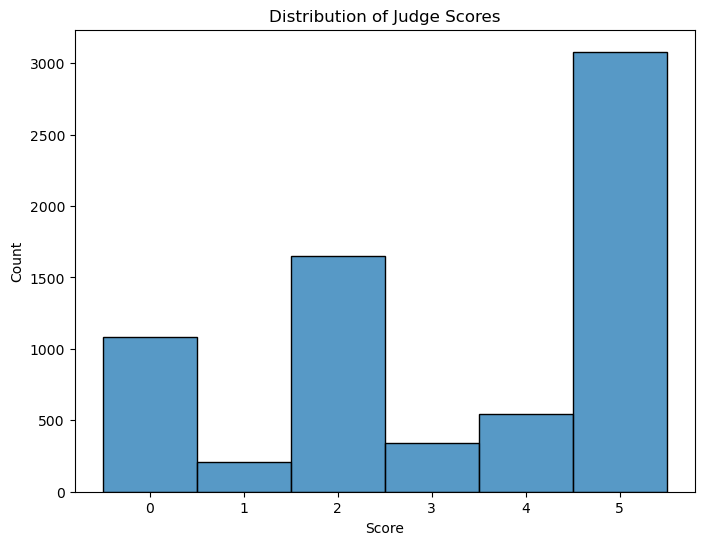

In [81]:
# Let's see the score distribution for all the predictions

plt.figure(figsize=(8, 6))
sns.histplot(data=judge_pred_df['score'], discrete=True)
plt.title('Distribution of Judge Scores')
plt.xlabel('Score')
plt.ylabel('Count')
plt.show()


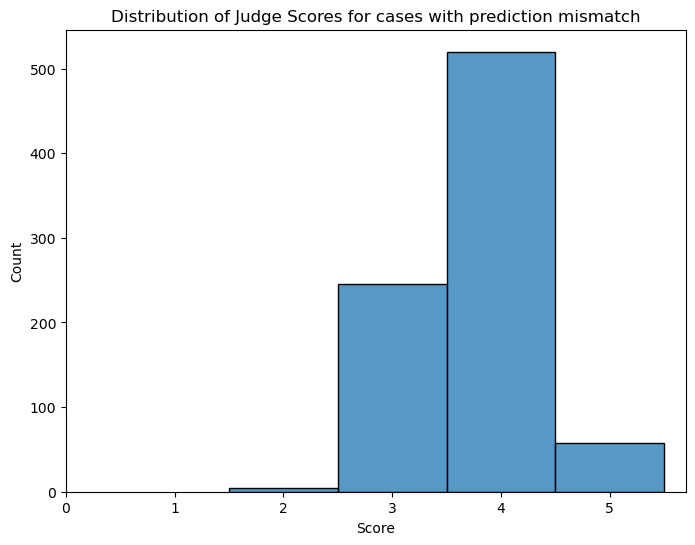

In [82]:
# Now the score distribution for the prediction which the judge considers as correct answer

plt.figure(figsize=(8, 6))
sns.histplot(data = \
             judge_pred_df \
             .loc[~exact_match_pred] \
             .loc[judged_correct_mask]['score'], discrete=True, bins=6)
plt.title('Distribution of Judge Scores for cases with prediction mismatch')
plt.xlabel('Score')
plt.ylabel('Count')
plt.xticks(range(6))
plt.show()


Not good. The LLM is very confident for these set of answers, even though we have just verified that not all them are consitent with the ground truth.

## Evaluation on the answers originally marked as correct

In [83]:
judge_pred_df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 6900 entries, Interaction_T1_13 to Feasibility_T6_1468
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   pred    6900 non-null   string
 1   score   6900 non-null   int32 
 2   reason  6900 non-null   string
dtypes: int32(1), string(2)
memory usage: 446.7+ KB


In [84]:
pred_percentages = judge_pred_df[exact_match_pred]['pred'].value_counts(normalize=True) * 100

print("\nPredictions:")
print("-" * 30)
print(f"{'incorrect':10}: {pred_percentages['incorrect']:6.2f}%\n"
      f"{'correct':10}: {pred_percentages['correct']:6.2f}%")
print("-" * 30)



Predictions:
------------------------------
incorrect :   0.16%
correct   :  99.84%
------------------------------


An interesting metric, on 95% of the cases the model is concording with the deterministic classification of the answer regex extraction method

Load the orignal model predictions to verify the judgement of the model.

In [85]:
judged_incorrect_mask = judge_pred_df[exact_match_pred]['pred'] == 'incorrect'

judge_pred_df[exact_match_pred][judged_incorrect_mask]


,pred,score,reason
id,,,
Interaction_T4_931,incorrect,2,The model's answer 'Ate the sandwich.' matches...
Interaction_T4_2724,incorrect,0,The model's answer 'Opened the door.' is a dir...
Interaction_T4_3746,incorrect,0,The model's answer 'Threw the broom' matches t...
Sequence_T2_1347,incorrect,2,The model's answer 'The dish' matches the grou...
Sequence_T3_1877,incorrect,2,The model's answer 'Opened the refrigerator' m...


Let's analyze some of the answers

### Distribution of confidence score

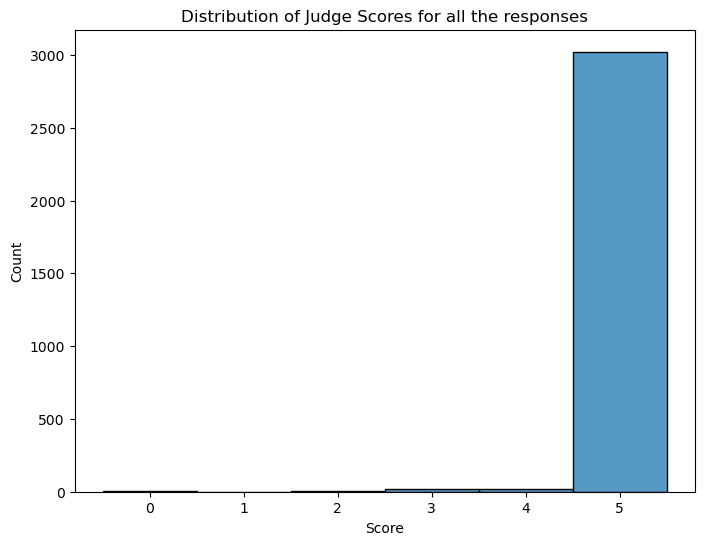

In [86]:
# Let's see the score distribution for all the predictions

plt.figure(figsize=(8, 6))
sns.histplot(data=judge_pred_df[exact_match_pred]['score'], discrete=True)
plt.title('Distribution of Judge Scores for all the responses')
plt.xlabel('Score')
plt.ylabel('Count')
plt.show()


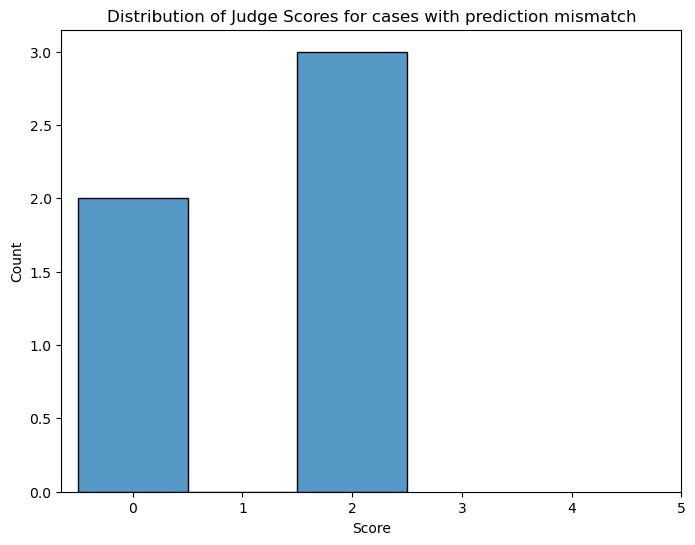

In [87]:
# Now the score distribution for the prediction which the judge considers as incorrect answers

plt.figure(figsize=(8, 6))
sns.histplot(data= \
             judge_pred_df \
             .loc[exact_match_pred]
             .loc[judged_incorrect_mask]['score'], discrete=True, bins=6)
plt.title('Distribution of Judge Scores for cases with prediction mismatch')
plt.xlabel('Score')
plt.ylabel('Count')
plt.xticks(range(6))
plt.show()


Let's check the mismatch cases where the Judge LLM is most confident (score > 2)

In [88]:
high_conf = judged_incorrect_mask[judge_pred_df['score'] > 2]
hig_conf_idxs = high_conf[high_conf].index
hig_conf_idxs


Index([], dtype='object', name='id')

In [89]:
idx = 'Sequence_T1_1194'


print(f"Index: {idx}")
print(f"Question: {gt_df.loc[idx]['question']}")
print(f"Ground truth answer: {gt_df.loc[idx]['text']}")
print(f"Extracted answer: {ans_df.loc[idx]['text']}")
print(f"\nOriginal answer:\n\n{predictions_df.loc[idx]['response']}")
print(f"\nJudge evlauation:\n"
      f" - verdict: {judge_pred_df.loc[idx]['pred']}\n"
      f" - score: {judge_pred_df.loc[idx]['score']}\n"
      f" - reason: {judge_pred_df.loc[idx]['reason']}\n")


Index: Sequence_T1_1194
Question: Which object did the person take after they put down the cup/glass/bottle?
Ground truth answer: The sandwich.
Extracted answer: The sandwich.

Original answer:

The sandwich.

Judge evlauation:
 - verdict: correct
 - score: 5
 - reason: The model's final answer is based on the fact that it correctly identified the object taken by the person after they put down the cup/glass/bottle, which was indeed 'the sandwich'.



Let's check the other answers

In [90]:
idx = random.choice(judged_incorrect_mask[judged_incorrect_mask].index)

print(f"Index: {idx}")
print(f"Question: {gt_df.loc[idx]['question']}")
print(f"Ground truth answer: {gt_df.loc[idx]['text']}")
print(f"Extracted answer: {ans_df.loc[idx]['text']}")
print(f"\nOriginal answer:\n\n{predictions_df.loc[idx]['response']}")
print(f"\nJudge evlauation:\n"
      f" - verdict: {judge_pred_df.loc[idx]['pred']}\n"
      f" - score: {judge_pred_df.loc[idx]['score']}\n"
      f" - reason: {judge_pred_df.loc[idx]['reason']}\n")


Index: Sequence_T3_1877
Question: What happened after the person ate the medicine?
Ground truth answer: Opened the refrigerator.
Extracted answer: Opened the refrigerator.

Original answer:

Opened the refrigerator.

Judge evlauation:
 - verdict: incorrect
 - score: 2
 - reason: The model's answer 'Opened the refrigerator' matches the ground truth answer, but it doesn't logically follow from eating medicine. The question asks what happened after eating the medicine, implying a consequence or effect of taking the medicine.



In [91]:
idx = 'Interaction_T1_2119'

print(f"Index: {idx}")
print(f"Question: {gt_df.loc[idx]['question']}")
print(f"Ground truth answer: {gt_df.loc[idx]['text']}")
print(f"Extracted answer: {ans_df.loc[idx]['text']}")
print(f"\nOriginal answer:\n\n{predictions_df.loc[idx]['response']}")
print(f"\nJudge evlauation:\n"
      f" - verdict: {judge_pred_df.loc[idx]['pred']}\n"
      f" - score: {judge_pred_df.loc[idx]['score']}\n"
      f" - reason: {judge_pred_df.loc[idx]['reason']}\n")


Index: Interaction_T1_2119
Question: Which object was put down by the person?
Ground truth answer: The book.
Extracted answer: The book.

Original answer:

The book.

Judge evlauation:
 - verdict: correct
 - score: 5
 - reason: The model's answer 'The book' matches the ground truth answer, indicating a correct prediction.



---

Look at the following question.  
The answer does not follow from the reasoning but do the generated token contribute to determine the answer? In other words, even tough the reasoning is not sound do these token influence the probability distribution of choosing the answer?

In [92]:
idx = 'Sequence_T6_3033'

print(f"Index: {idx}")
print(f"Question: {gt_df.loc[idx]['question']}")
print(f"Ground truth answer: {gt_df.loc[idx]['text']}")
print(f"Extracted answer: {ans_df.loc[idx]['text']}")
print(f"\nOriginal answer:\n\n{predictions_df.loc[idx]['response']}")
print(f"\nJudge evlauation:\n"
      f" - verdict: {judge_pred_df.loc[idx]['pred']}\n"
      f" - score: {judge_pred_df.loc[idx]['score']}\n"
      f" - reason: {judge_pred_df.loc[idx]['reason']}\n")


Index: Sequence_T6_3033
Question: What did the person do to the cup/glass/bottle before putting down the dish?
Ground truth answer: Took.
Extracted answer: Took.

Original answer:

Took.

Judge evlauation:
 - verdict: correct
 - score: 5
 - reason: The model's answer 'Took' matches the ground truth answer 'Took', indicating a correct prediction.



## Evaluation on the entire dataset

In [93]:
judge_pred_correct_mask = (judge_pred_df['pred'] == 'correct')


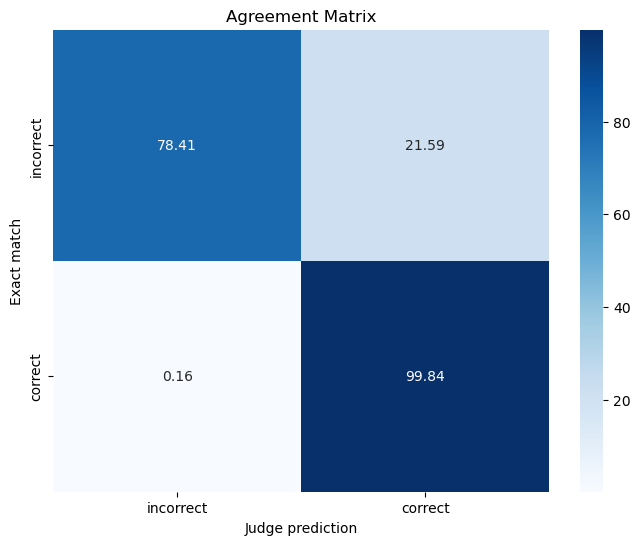

In [94]:
# Compute the confusion matrix

exact_match_labels = exact_match_pred.astype(int)
judge_pred_labels = judge_pred_correct_mask.astype(int)

cm = confusion_matrix(exact_match_labels, judge_pred_labels)

# Normalize the confusion matrix to percentage
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

# Plot the confusion matrix using Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', 
            xticklabels=['incorrect', 'correct'], 
            yticklabels=['incorrect', 'correct'])
plt.xlabel('Judge prediction')
plt.ylabel('Exact match')
plt.title('Agreement Matrix')
plt.show()


In [95]:
def print_acc(eval_df, acc_fn):
    print(f"{'Question type':<15}{'Total':^15}{'Accuracy':^10}\n")

    total = eval_df.index.str.startswith('Interaction').sum()
    acc = acc_fn(eval_df[eval_df.index.str.startswith('Interaction')])
    print(f"{'Interaction':<15}{total:^15}{acc:^10.2%}")

    total = eval_df.index.str.startswith('Sequence').sum()
    acc = acc_fn(eval_df[eval_df.index.str.startswith('Sequence')])
    print(f"{'Sequence':<15}{total:^15}{acc:^10.2%}")

    total = eval_df.index.str.startswith('Prediction').sum()
    acc = acc_fn(eval_df[eval_df.index.str.startswith('Prediction')])
    print(f"{'Prediction':<15}{total:^15}{acc:^10.2%}")

    total = eval_df.index.str.startswith('Feasibility').sum()
    acc = acc_fn(eval_df[eval_df.index.str.startswith('Feasibility')])
    print(f"{'Feasibility':<15}{total:^15}{acc:^10.2%}")


In [96]:
print('LLM as a Judge accuracy\n')
print_acc(judge_pred_correct_mask, lambda x: x.sum()/x.shape[0])


LLM as a Judge accuracy

Question type       Total      Accuracy 

Interaction         2308        58.84%  
Sequence            3485        56.41%  
Prediction           621        51.85%  
Feasibility          486        50.62%  


In [97]:
print('Answer extraction through regex accuracy\n')
print_acc(exact_match_pred, lambda x: x.sum()/x.shape[0])


Answer extraction through regex accuracy

Question type       Total      Accuracy 

Interaction         2308        44.58%  
Sequence            3485        44.68%  
Prediction           621        43.16%  
Feasibility          486        44.44%  


In [98]:
# Note: to access meta-llama you have to first accept the licence agreement
from transformers import AutoTokenizer
import os

hugg_key = os.environ['HUGGINGFACE_KEY']

tokenizer = AutoTokenizer.from_pretrained(
                'meta-llama/Llama-3.2-3B-Instruct', 
                token=hugg_key)


In [99]:
# 128000 : <|begin_of_text|>
# 128006 : <|start_header_id|>
# 128007 : <|end_header_id|>

a = tokenizer.encode("<|start_header_id|>system<|end_header_id|><|eom_id|>")
a


[128000, 128006, 9125, 128007, 128008]

In [100]:
# "chat_template": 
# "{{- bos_token }}\n{%- if custom_tools is defined %}\n    {%- set tools = custom_tools %}\n{%- endif %}\n{%- if not tools_in_user_message is defined %}\n    {%- set tools_in_user_message = true %}\n{%- endif %}\n{%- if not date_string is defined %}\n    {%- if strftime_now is defined %}\n        {%- set date_string = strftime_now(\"%d %b %Y\") %}\n    {%- else %}\n        {%- set date_string = \"26 Jul 2024\" %}\n    {%- endif %}\n{%- endif %}\n{%- if not tools is defined %}\n    {%- set tools = none %}\n{%- endif %}\n\n{#- This block extracts the system message, so we can slot it into the right place. #}\n{%- if messages[0]['role'] == 'system' %}\n    {%- set system_message = messages[0]['content']|trim %}\n    {%- set messages = messages[1:] %}\n{%- else %}\n    {%- set system_message = \"\" %}\n{%- endif %}\n\n{#- System message #}\n{{- \"<|start_header_id|>system<|end_header_id|>\\n\\n\" }}\n{%- if tools is not none %}\n    {{- \"Environment: ipython\\n\" }}\n{%- endif %}\n{{- \"Cutting Knowledge Date: December 2023\\n\" }}\n{{- \"Today Date: \" + date_string + \"\\n\\n\" }}\n{%- if tools is not none and not tools_in_user_message %}\n    {{- \"You have access to the following functions. To call a function, please respond with JSON for a function call.\" }}\n    {{- 'Respond in the format {\"name\": function name, \"parameters\": dictionary of argument name and its value}.' }}\n    {{- \"Do not use variables.\\n\\n\" }}\n    {%- for t in tools %}\n        {{- t | tojson(indent=4) }}\n        {{- \"\\n\\n\" }}\n    {%- endfor %}\n{%- endif %}\n{{- system_message }}\n{{- \"<|eot_id|>\" }}\n\n{#- Custom tools are passed in a user message with some extra guidance #}\n{%- if tools_in_user_message and not tools is none %}\n    {#- Extract the first user message so we can plug it in here #}\n    {%- if messages | length != 0 %}\n        {%- set first_user_message = messages[0]['content']|trim %}\n        {%- set messages = messages[1:] %}\n    {%- else %}\n        {{- raise_exception(\"Cannot put tools in the first user message when there's no first user message!\") }}\n{%- endif %}\n    {{- '<|start_header_id|>user<|end_header_id|>\\n\\n' -}}\n    {{- \"Given the following functions, please respond with a JSON for a function call \" }}\n    {{- \"with its proper arguments that best answers the given prompt.\\n\\n\" }}\n    {{- 'Respond in the format {\"name\": function name, \"parameters\": dictionary of argument name and its value}.' }}\n    {{- \"Do not use variables.\\n\\n\" }}\n    {%- for t in tools %}\n        {{- t | tojson(indent=4) }}\n        {{- \"\\n\\n\" }}\n    {%- endfor %}\n    {{- first_user_message + \"<|eot_id|>\"}}\n{%- endif %}\n\n{%- for message in messages %}\n    {%- if not (message.role == 'ipython' or message.role == 'tool' or 'tool_calls' in message) %}\n        {{- '<|start_header_id|>' + message['role'] + '<|end_header_id|>\\n\\n'+ message['content'] | trim + '<|eot_id|>' }}\n    {%- elif 'tool_calls' in message %}\n        {%- if not message.tool_calls|length == 1 %}\n            {{- raise_exception(\"This model only supports single tool-calls at once!\") }}\n        {%- endif %}\n        {%- set tool_call = message.tool_calls[0].function %}\n        {{- '<|start_header_id|>assistant<|end_header_id|>\\n\\n' -}}\n        {{- '{\"name\": \"' + tool_call.name + '\", ' }}\n        {{- '\"parameters\": ' }}\n        {{- tool_call.arguments | tojson }}\n        {{- \"}\" }}\n        {{- \"<|eot_id|>\" }}\n    {%- elif message.role == \"tool\" or message.role == \"ipython\" %}\n        {{- \"<|start_header_id|>ipython<|end_header_id|>\\n\\n\" }}\n        {%- if message.content is mapping or message.content is iterable %}\n            {{- message.content | tojson }}\n        {%- else %}\n            {{- message.content }}\n        {%- endif %}\n        {{- \"<|eot_id|>\" }}\n    {%- endif %}\n{%- endfor %}\n{%- if add_generation_prompt %}\n    {{- '<|start_header_id|>assistant<|end_header_id|>\\n\\n' }}\n{%- endif %}\n",
#   "clean_up_tokenization_spaces": true,
